In [44]:
import json
import pathlib

import pandas as pd
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols

DATA_DIR = pathlib.Path('../data')

## Optimal

In [55]:
with (DATA_DIR / 'boardOptimals.json').open() as f:
    optimal = json.load(f)

## Load data

In [2]:
def load_data(filepath):
    with open(filepath) as f:
        return json.load(f)

In [3]:
def to_record(experiment):
    return {
        'board_id': experiment['gs']['boardID'],
        'ticks': experiment['gs']['tick'],
        'impossible_actions': experiment['gs']['impossibleActionCount'],
        'first_winner_tick': experiment['gs']['firstWinnerTick'],
        'heuristic': experiment['agentsParams'][0]['heuristic_method'],
    }

In [59]:
optimal

{'boards': [{'boardID': 0, 'tick': 9, 'firstWinnerTick': 9},
  {'boardID': 1, 'tick': 11, 'firstWinnerTick': 8},
  {'boardID': 2, 'tick': 28, 'firstWinnerTick': 17},
  {'boardID': 3, 'tick': 10, 'firstWinnerTick': 9},
  {'boardID': 4, 'tick': 15, 'firstWinnerTick': 8},
  {'boardID': 5, 'tick': 10, 'firstWinnerTick': 10},
  {'boardID': 6, 'tick': 10, 'firstWinnerTick': 8}]}

In [63]:
df = pd.DataFrame.from_records(to_record(x) for x in load_data(DATA_DIR / '200_ticks.json'))
df['success'] = df['ticks'] < 200
df['second_winner_lag'] = df['ticks'] - df['first_winner_tick']
df['solo'] = (df['heuristic'] % 2).astype(bool)
df['binary'] = df['heuristic'] < 3

def is_optimal(experiment):
    print(experiment)
    for board in optimal['boards']:
        if board['boardID'] == experiment['board_id']:
            return experiment['tick'] <= board['tick']
    raise AssertionError("Shouldn't happen")
df['optimal'] = df.apply(is_optimal, axis=1)

board_id                 0
first_winner_tick       17
heuristic                1
impossible_actions       0
ticks                   17
success               True
second_winner_lag        0
solo                  True
binary                True
Name: 0, dtype: object
board_id                 0
first_winner_tick       17
heuristic                1
impossible_actions       0
ticks                   17
success               True
second_winner_lag        0
solo                  True
binary                True
Name: 0, dtype: object


KeyError: ('tick', 'occurred at index 0')

{'boards': [{'boardID': 0, 'tick': 9, 'firstWinnerTick': 9},
  {'boardID': 1, 'tick': 11, 'firstWinnerTick': 8},
  {'boardID': 2, 'tick': 28, 'firstWinnerTick': 17},
  {'boardID': 3, 'tick': 10, 'firstWinnerTick': 9},
  {'boardID': 4, 'tick': 15, 'firstWinnerTick': 8},
  {'boardID': 5, 'tick': 10, 'firstWinnerTick': 10},
  {'boardID': 6, 'tick': 10, 'firstWinnerTick': 8}]}

## Success percentage

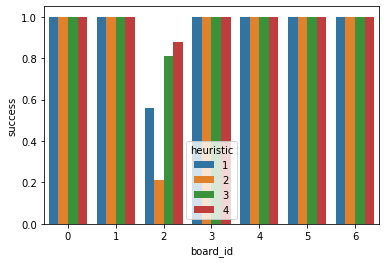

In [5]:
sns.barplot(
    y='success',
    x='board_id',
    hue='heuristic',
    data=df.groupby(['board_id', 'heuristic'])['success'].mean().reset_index(),
)

## Analysis including failures

### Ticks

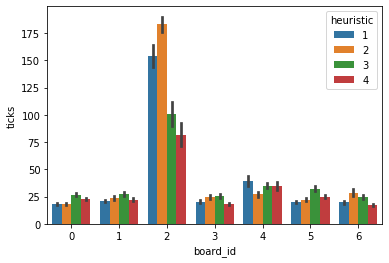

In [6]:
sns.barplot(
    y='ticks',
    x='board_id',
    hue='heuristic',
    data=df,
)

### Impossible actions

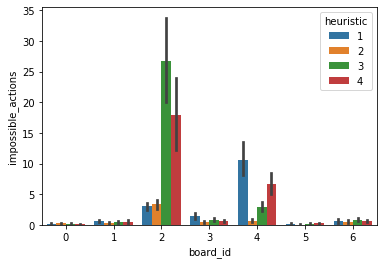

In [7]:
sns.barplot(
    y='impossible_actions',
    x='board_id',
    hue='heuristic',
    data=df,
)

### 2nd winner lag

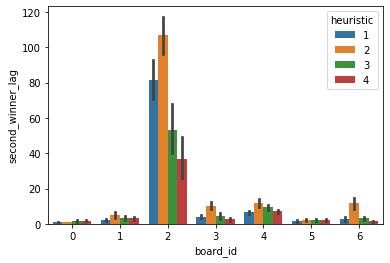

In [8]:
sns.barplot(
    y='second_winner_lag',
    x='board_id',
    hue='heuristic',
    data=df,
)

## Successfull runs only

### Ticks

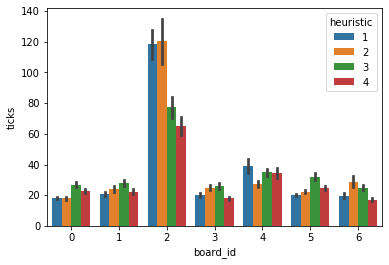

In [9]:
sns.barplot(
    y='ticks',
    x='board_id',
    hue='heuristic',
    data=df[df['success']],
)

### Impossible actions

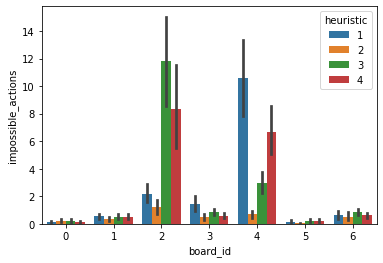

In [10]:
sns.barplot(
    y='impossible_actions',
    x='board_id',
    hue='heuristic',
    data=df[df['success']],
)

### 2nd winner lag

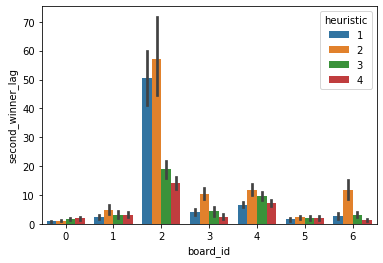

In [11]:
sns.barplot(
    y='second_winner_lag',
    x='board_id',
    hue='heuristic',
    data=df[df['success']],
)

## Is the number of ticks different between solo and joint

In [53]:
stats.ttest_ind(df['ticks'][df['solo'] == True], df['ticks'][df['solo'] == False])

Ttest_indResult(statistic=0.6675240298290025, pvalue=0.5044925157552055)

## Pairwise everything!

Don't tell my supervisors :)

/home/nagasaki45/code/game_design_ii/cooperative-ai/analysis/env/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/nagasaki45/code/game_design_ii/cooperative-ai/analysis/env/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


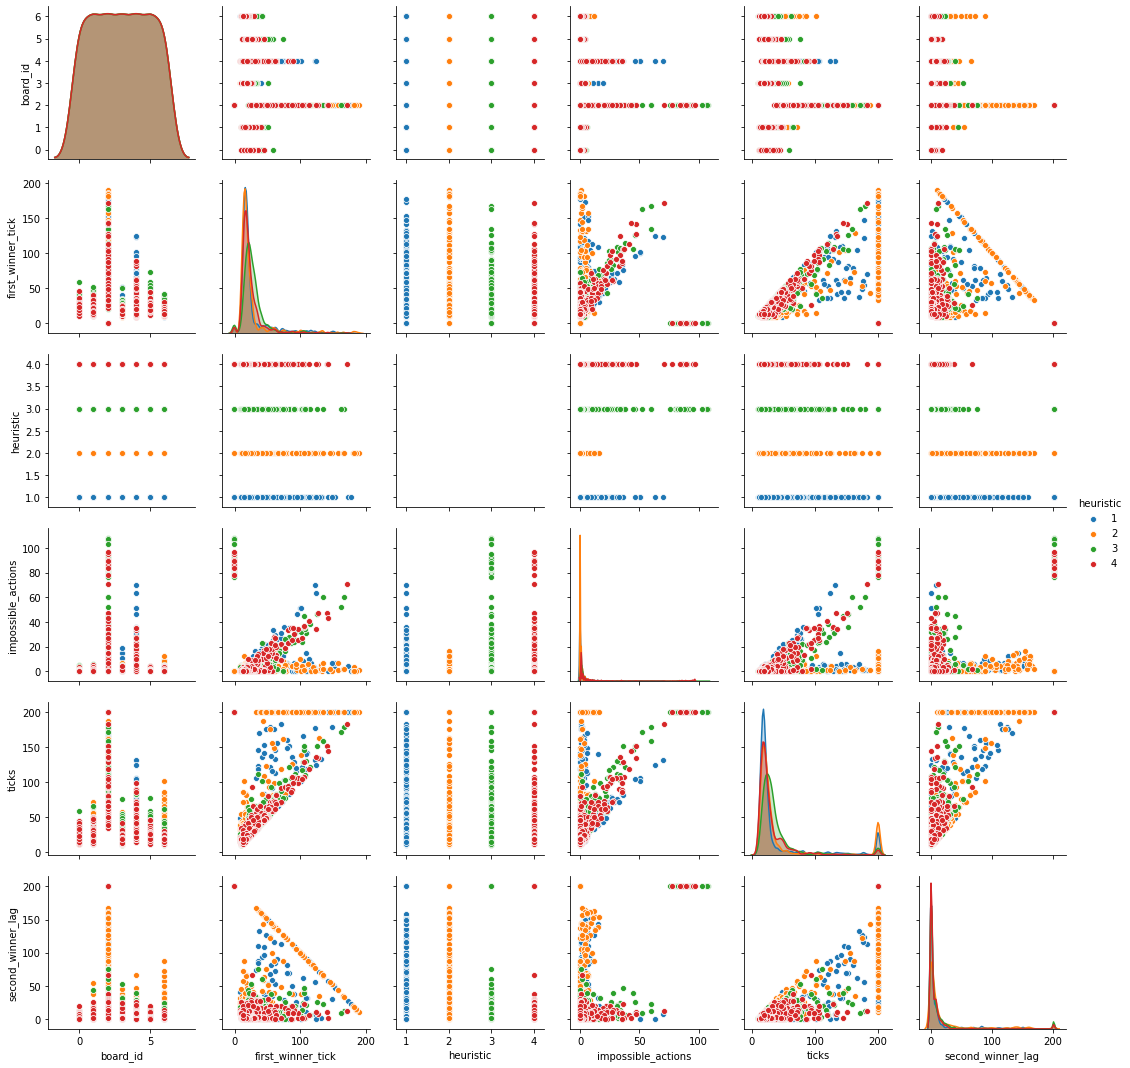

In [29]:
sns.pairplot(df.drop('success', axis=1), hue='heuristic')

# ANOVAAAAAAAAA!

### ticks ~ heuristic * board

In [13]:
lm = ols('ticks ~ C(heuristic) * C(board_id)', data=df).fit()

In [14]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  ticks   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     384.7
Date:                Thu, 13 Jun 2019   Prob (F-statistic):               0.00
Time:                        12:03:08   Log-Likelihood:                -12469.
No. Observations:                2800   AIC:                         2.499e+04
Df Residuals:                    2772   BIC:                         2.516e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

In [15]:
sm.stats.anova_lm(lm, typ=2)

,sum_sq,df,F,PR(>F)
C(heuristic),8.599125e+04,3.0,65.683911,5.009681e-41
C(board_id),3.830049e+06,6.0,1462.780218,0.000000e+00
C(heuristic):C(board_id),6.163128e+05,18.0,78.461156,8.190075e-232
Residual,1.209671e+06,2772.0,NaN,NaN


### success ~ heuristic * board

In [23]:
lm = ols('impossible_actions ~ C(heuristic) * C(board_id)', data=df).fit()

In [25]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     impossible_actions   R-squared:                       0.297
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     43.37
Date:                Thu, 13 Jun 2019   Prob (F-statistic):          2.36e-189
Time:                        12:20:16   Log-Likelihood:                -10176.
No. Observations:                2800   AIC:                         2.041e+04
Df Residuals:                    2772   BIC:                         2.057e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                              0.1300      0.921      0.141      0.888      -1.676       1.936
C(heuristic)[T.2]                      0.1000      1.303      0.077      0.939      -2.454       2.654
C(heuristic)[T.3]                      0.0700      1.303      0.054      0.957      -2.484       2.624
C(heuristic)[T.4]                     -0.0200      1.303     -0.015      0.988      -2.574       2.534
C(board_id)[T.1]                       0.4300      1.303      0.330      0.741      -2.124       2.984
C(board_id)[T.2]                       2.8800      1.303      2.211      0.027       0.326       5.434
C(board_id)[T.3]                       1.3000      1.303      0.998      0.318      -1.254       3.854
C(board_id)[T.4]                      10.4600      1.303      8.031      0.000       7.906      13.014
C(board_id)[T.5]                       0.0400      1.303      0.031      0.976      -2.514       2.594
C(board_id)[T.6]                       0.5100      1.303      0.392      0.695      -2.044       3.064
C(heuristic)[T.2]:C(board_id)[T.1]    -0.3200      1.842     -0.174      0.862      -3.932       3.292
C(heuristic)[T.3]:C(board_id)[T.1]    -0.1400      1.842     -0.076      0.939      -3.752       3.472
C(heuristic)[T.4]:C(board_id)[T.1]    -0.0100      1.842     -0.005      0.996      -3.622       3.602
C(heuristic)[T.2]:C(board_id)[T.2]     0.2300      1.842      0.125      0.901      -3.382       3.842
C(heuristic)[T.3]:C(board_id)[T.2]    23.6600      1.842     12.844      0.000      20.048      27.272
C(heuristic)[T.4]:C(board_id)[T.2]    14.9400      1.842      8.111      0.000      11.328      18.552
C(heuristic)[T.2]:C(board_id)[T.3]    -1.0500      1.842     -0.570      0.569      -4.662       2.562
C(heuristic)[T.3]:C(board_id)[T.3]    -0.6400      1.842     -0.347      0.728      -4.252       2.972
C(heuristic)[T.4]:C(board_id)[T.3]    -0.8100      1.842     -0.440      0.660      -4.422       2.802
C(heuristic)[T.2]:C(board_id)[T.4]   -10.0000      1.842     -5.429      0.000     -13.612      -6.388
C(heuristic)[T.3]:C(board_id)[T.4]    -7.6600      1.842     -4.158      0.000     -11.272      -4.048
C(heuristic)[T.4]:C(board_id)[T.4]    -3.9300      1.842     -2.133      0.033      -7.542      -0.318
C(heuristic)[T.2]:C(board_id)[T.5]    -0.2300      1.842     -0.125      0.901      -3.842       3.382
C(heuristic)[T.3]:C(board_id)[T.5]    -0.0200      1.842     -0.011      0.991      -3.632       3.592
C(heuristic)[T.4]:C(board_id)[T.5]     0.0800      1.842      0.043      0.965      -3.532       3.692
C(heuristic)[T.2]:C(board_id)[T.6]    -0.2200      1.842     -0.119      0.905      -3.832       3.392
C(heuristic)[T.3]:C(board_id)[T.6]     0.1400      1.842      0.076      0.939      -3.472      

In [26]:
sm.stats.anova_lm(lm, typ=2)

,sum_sq,df,F,PR(>F)
C(heuristic),5928.881071,3.0,23.297359,6.858819e-15
C(board_id),53046.087143,6.0,104.221498,1.177186e-118
C(heuristic):C(board_id),40363.601429,18.0,26.434592,3.356740e-82
Residual,235146.230000,2772.0,NaN,NaN
